## Calibration Simulation

This notebooks views results of fits to purely simulated data. It is mostly just to test that the likelihoods are correct etc.

In [34]:
import matplotlib.pyplot as plt
import numpy as np
from edges_cal import modelling as mdl
from pathlib import Path

import mcmc_utils as mutl
from edges_estimate.eor_models import AbsorptionProfile
from edges_estimate.fitting import SemiLinearFit
from getdist import plots

import alan_data_utils as utils
import alan_data as adata
import glob
import run_alan_data_simulation_mcmc as mcmc
from scipy import optimize
import notebook_utils as nutl
import pickle
from multiprocessing import Pool
from astropy import units as u
from edges_cal.modelling import LinLog
plt.ion()

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
nutl.setup_mpl()

In [3]:
calobs32 = utils.get_calobs(smooth=32)

In [4]:
names = sorted(Path('outputs/alan_field_and_cal_simulation/').glob("*"))

lks = {}
for name in names:
    print(name.name)
    lks[name.name] = mcmc.precal.get_likelihood_from_label(name.name)

c06_w05_smooth08_tns0500_ign[()]_s11()_antsimFalse_fg5_simulTrue_taufxTrue_ns01_nd01
6 6 6
c06_w05_smooth08_tns0500_ign[()]_s11()_antsimFalse_fg5_simulTrue_taufxTrue_ns01_nd01_noiseFalse
6 6 6


In [35]:
linlog5 = LinLog(n_terms=5)

In [5]:
nonoise = lks['c06_w05_smooth08_tns0500_ign[()]_s11()_antsimFalse_fg5_simulTrue_taufxTrue_ns01_nd01_noiseFalse']

In [6]:
for p in nonoise.partial_linear_model.child_active_params:
    print(p.name, p.fiducial)

t_lns_0 1486.2516116267518
t_lns_1 -195.77114433587195
t_lns_2 63.417001059825424
t_lns_3 -18.881490657966474
t_lns_4 6.661929843911561
t_lns_5 -3.5220425451525816
A 0.5
nu0 78.5
w 15.0


In [7]:
ctx = nonoise.partial_linear_model.get_ctx()

In [8]:
fit, data, var = nonoise.partial_linear_model.reduce_model(ctx=ctx)

In [9]:
nonoise.tunchat((fit,data,var), None)

(183.82804715883805,
 -2.9460563306292595,
 1.3015824111818322,
 -0.47989103599383837,
 0.26030551906533733)

In [10]:
calobs32.Tunc_poly.coefficients

array([  0.33799743,  -0.44086126,   1.22185247,  -2.94852453,
       183.8256624 ])

In [14]:
nonoise.data['q']['ant']*calobs32.C1(adata.sky_freq*u.MHz)*1000 - adata.loss*adata.bmcorr*nonoise.data['k0']['ant']*ctx['eor_spectrum'] - adata.loss_temp*nonoise.data['k0']['ant']

array([3657.71219826, 3606.61913491, 3554.07323391, 3500.363801  ,
       3445.72985658, 3390.41196966, 3334.61741485, 3278.54466557,
       3222.36954093, 3166.24409156, 3110.31623821, 3054.70465489,
       2999.52681705, 2944.86773539, 2890.82879633, 2837.46801694,
       2784.85179815, 2733.03150774, 2682.05046324, 2631.94161611,
       2582.73027476, 2534.44029354, 2487.0812064 , 2440.66448161,
       2395.19527798, 2350.67537506, 2307.0983465 , 2264.46122283,
       2222.75470619, 2181.96555726, 2142.08411083, 2103.09564264,
       2064.98605103, 2027.73305331, 1991.32233374, 1955.73416965,
       1920.94883156, 1886.94795163, 1853.71451097, 1821.22498188,
       1789.46087853, 1758.40564217, 1728.03783925, 1698.33755437,
       1669.28764469, 1640.86877605, 1613.06391977, 1585.85444536,
       1559.22382324, 1533.15306315, 1507.62843366, 1482.63264211,
       1458.15038412, 1434.16631006, 1410.66632114, 1387.63147343,
       1365.05347442, 1342.915607  , 1321.20347437, 1299.90871

In [19]:
f = adata.sky_freq*u.MHz

In [21]:
nonoise.data['raw_basis'].shape

(26, 4214)

In [29]:
Ksrcs = calobs32.get_K()

In [26]:
labcal = utils.get_labcal(calobs32)

In [28]:
Kant = labcal.get_gamma_coeffs(freq=f)

In [ ]:
K = calobs32.get_K

In [36]:
nonoise.nwfg_model.parameters

[183.83439468087556,
 -2.9654673838523253,
 1.2264762659950659,
 -0.44787624103983154,
 0.35414719138108325,
 -9.406922688532605,
 -3.6545816421688584,
 -7.442216692485366,
 4.58330394614584,
 -2.7161942206239145,
 10.61304302268523,
 8.77270389022864,
 -3.5126354123966226,
 -1.5508055757289685,
 0.5838724100861521,
 301.54802041068535,
 -0.03744231155552039,
 -0.008223630003482786,
 0.019683697218828282,
 0.030676355120969553,
 -0.005338558722536188,
 1747.7380343018451,
 -122.98105236106696,
 -61.086516075406465,
 82.92788576982501,
 179.6115625719181]

In [38]:
(
    calobs32.Tunc(f)*Kant[1] + 
    calobs32.Tcos(f)*Kant[2] + 
    calobs32.Tsin(f)*Kant[3] - 
    (calobs32.t_load - calobs32.C2(f)) + 
    adata.loss*adata.bmcorr* Kant[0]*linlog5(
        x=f.value, 
        parameters=[1747.7380343018451, -122.98105236106696, -61.086516075406465, 82.92788576982501, 179.6115625719181]
    ) 
)

array([3657.86710897, 3606.75904987, 3554.20786252, 3500.49438046,
       3445.86059164, 3390.54474216, 3334.75521618, 3278.68784105,
       3222.5173428 , 3166.397764  , 3110.47281373, 3054.86524118,
       2999.68581841, 2945.02901211, 2890.98658457, 2837.62591132,
       2785.0064797 , 2733.18455064, 2682.20127733, 2632.09181246,
       2582.87884452, 2534.58708014, 2487.22673909, 2440.81095504,
       2395.34086668, 2350.81901867, 2307.24150814, 2264.60172843,
       2222.89323029, 2182.10183866, 2142.21711325, 2103.22368638,
       2065.10807089, 2027.85038303, 1991.4328778 , 1955.83883758,
       1921.04714911, 1887.03894524, 1853.79879797, 1821.30308459,
       1789.53240612, 1758.46995155, 1728.09656108, 1698.39112421,
       1669.33735667, 1640.91478466, 1613.10772254, 1585.89625473,
       1559.26377217, 1533.19305179, 1507.6680205 , 1482.67270401,
       1458.19124601, 1434.20880166, 1410.71004649, 1387.67765629,
       1365.10086525, 1342.96603512, 1321.25682261, 1299.96384

In [15]:
nonoise.data['q']['ant']*ctx['tns_field'] - adata.loss*adata.bmcorr*nonoise.data['k0']['ant']*ctx['eor_spectrum'] - adata.loss_temp*nonoise.data['k0']['ant']

array([3657.67298979, 3606.58346393, 3554.04086592, 3500.33450672,
       3445.70341341, 3390.3881624 , 3334.59603662, 3278.52551826,
       3222.35243571, 3166.22884916, 3110.30268904, 3054.69263913,
       2999.51618459, 2944.85834579, 2890.82051853, 2837.46072912,
       2784.84538745, 2733.02586994, 2682.04550243, 2631.93724436,
       2582.72641175, 2534.43686619, 2487.07814855, 2440.66173357,
       2395.19278623, 2350.67309187, 2307.09622957, 2264.45923498,
       2222.75281499, 2181.96373474, 2142.08233317, 2103.09388984,
       2064.98430669, 2027.73130431, 1991.32056997, 1955.73238382,
       1920.94701892, 1886.94610975, 1853.71263953, 1821.22308246,
       1789.45895445, 1758.40369827, 1728.03588171, 1698.33559056,
       1669.285683  , 1640.86682578, 1613.06199091, 1585.85254853,
       1559.22196949, 1533.1512639 , 1507.62670053, 1482.63098686,
       1458.1488185 , 1434.16484574, 1410.6649696 , 1387.63024588,
       1365.05238172, 1342.91465955, 1321.20268205, 1299.90808

In [9]:
fit.residual

array([-0.06696278, -0.06534511, -0.06374692, ..., -0.00065897,
        0.00135565,  0.00429467])

In [10]:
from edges_cal.modelling import LinLog

In [12]:
from alan_data import sky_freq, sky_temp

In [13]:
plm = nonoise.partial_linear_model

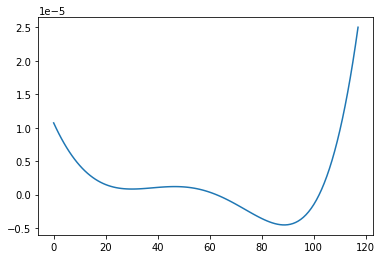

In [34]:
plt.plot(calobs32.C1(adata.sky_freq*u.MHz)*1000 / ctx['tns_field'] - 1)

In [30]:
ctx['tns_field']

array([1724.4194954 , 1718.54413832, 1712.74898986, 1707.03250966,
       1701.3931882 , 1695.82954653, 1690.34013576, 1684.92353673,
       1679.57835963, 1674.30324353, 1669.09685605, 1663.95789296,
       1658.88507772, 1653.87716118, 1648.93292112, 1644.05116186,
       1639.23071389, 1634.47043346, 1629.76920216, 1625.12592659,
       1620.53953789, 1616.00899139, 1611.53326621, 1607.11136483,
       1602.74231276, 1598.42515807, 1594.15897105, 1589.94284379,
       1585.77588978, 1581.65724355, 1577.58606022, 1573.56151513,
       1569.58280348, 1565.64913986, 1561.75975793, 1557.91390997,
       1554.11086651, 1550.34991593, 1546.63036407, 1542.95153381,
       1539.31276471, 1535.71341258, 1532.15284912, 1528.6304615 ,
       1525.14565197, 1521.69783744, 1518.28644916, 1514.91093223,
       1511.57074526, 1508.26535997, 1504.99426078, 1501.75694442,
       1498.55291955, 1495.38170634, 1492.24283607, 1489.13585077,
       1486.06030281, 1483.01575447, 1480.00177759, 1477.01795

In [15]:
plm.data

{'q': {'ambient': array([-0.00327821, -0.00327911, -0.00328001, ..., -0.00435453,
         -0.00435575, -0.00435696]),
  'hot_load': array([0.05452623, 0.0545522 , 0.05457814, ..., 0.07208605, 0.07209749,
         0.0721089 ]),
  'open': array([-0.06822767, -0.06809418, -0.06795805, ..., -0.09536457,
         -0.09538371, -0.09539644]),
  'short': array([-0.04876859, -0.04897686, -0.04918689, ..., -0.06256331,
         -0.06258663, -0.06261593]),
  'ant': array([2.12163779, 2.09916095, 2.0755864 , 2.05107744, 2.02577019,
         1.9998036 , 1.9732988 , 1.94637332, 1.91913272, 1.89166968,
         1.86407552, 1.83642509, 1.80879328, 1.78123624, 1.75382057,
         1.72658718, 1.69958244, 1.67284391, 1.64640452, 1.62029104,
         1.59452566, 1.56912979, 1.54411602, 1.51949811, 1.49528591,
         1.47148708, 1.44810406, 1.42514136, 1.40259938, 1.38047587,
         1.35877068, 1.33748028, 1.31660136, 1.29612519, 1.27604788,
         1.25636188, 1.23705939, 1.21813325, 1.19957692, 1.

In [14]:
plm.linear_model?

Signature:     
plm.linear_model(
    x: 'np.ndarray | None' = None,
    parameters: 'Sequence | None' = None,
    indices: 'Sequence | None' = None,
) -> 'np.ndarray'
Type:           FixedLinearModel
String form:   
FixedLinearModel(model=CompositeModel(models={'tunc': Polynomial(parameters=(183.83439468087556,  <...>  50.06103516, 50.10986328, ..., 98.059082  ,
           98.449707  , 98.840332  ]), _init_basis=None)
File:           /data4/smurray/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py
Docstring:     
A base class for a linear model fixed at a certain set of co-ordinates.

Using this class caches the basis functions at the particular coordinates, and thus
speeds up the fitting of multiple sets of data at those co-ordinates.

Parameters
----------
model
    The linear model to evaluate at the co-ordinates
x
    A set of co-ordinates at which to evaluate the model.
init_basis
    If the basis functions of the model, evaluated at x, are known already, they
    can

In [17]:
fit2 = linlog5.fit(xdata=sky_freq, ydata=data[-len(sky_freq):])

In [18]:
fit2.model_parameters

(1362.4180005088067,
 -821.5298013084523,
 175.72298640771118,
 -1133.4607464893636,
 -12730.01786260693)

In [20]:
nonoise.nwfg_model.parameters

[183.83439468087556,
 -2.9654673838523253,
 1.2264762659950659,
 -0.44787624103983154,
 0.35414719138108325,
 -9.406922688532605,
 -3.6545816421688584,
 -7.442216692485366,
 4.58330394614584,
 -2.7161942206239145,
 10.61304302268523,
 8.77270389022864,
 -3.5126354123966226,
 -1.5508055757289685,
 0.5838724100861521,
 301.54802041068535,
 -0.03744231155552039,
 -0.008223630003482786,
 0.019683697218828282,
 0.030676355120969553,
 -0.005338558722536188,
 1747.7380343018451,
 -122.98105236106696,
 -61.086516075406465,
 82.92788576982501,
 179.6115625719181]

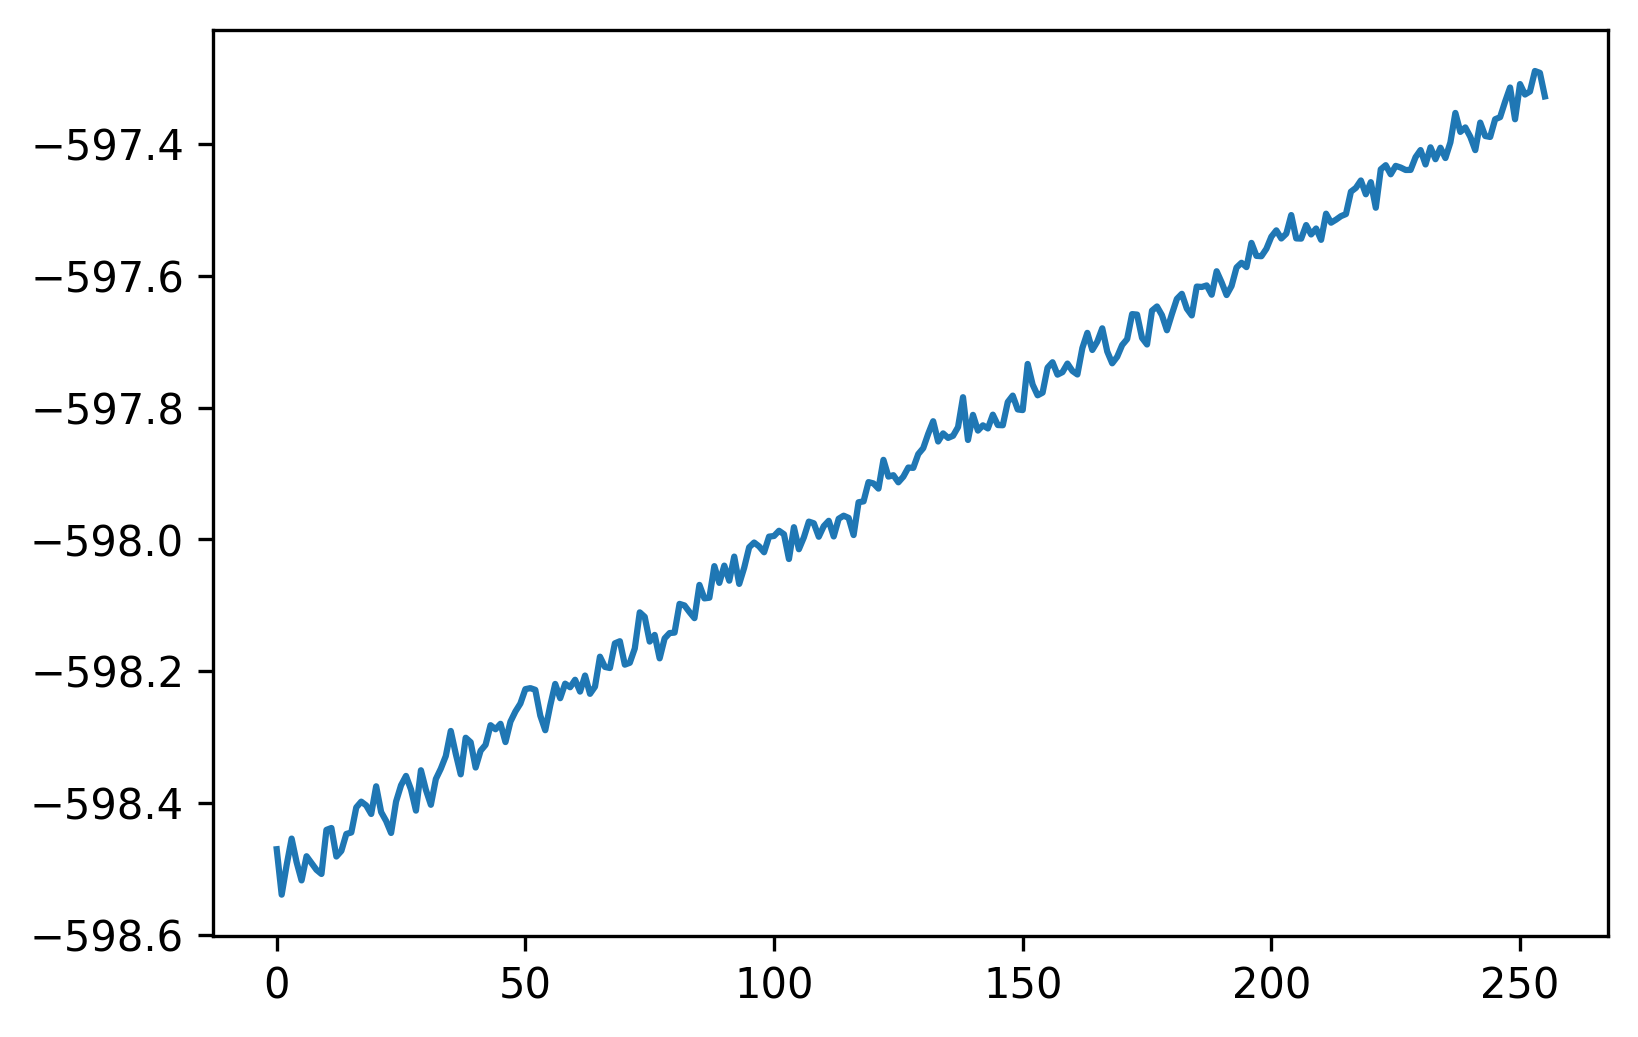

In [24]:
plt.plot(data[:calobs32.freq.n] - calobs32.ambient.averaged_spectrum)

In [22]:
fit3 = linlog5.fit(xdata=sky_freq, ydata=sky_temp)

In [23]:
fit3.model_parameters

(1747.7380343018451,
 -122.98105236106696,
 -61.086516075406465,
 82.92788576982501,
 179.6115625719181)

In [21]:
ctx

{'tns': array([1774.50522007, 1773.67799401, 1772.85225691, ..., 1338.61173825,
        1338.38375696, 1338.15586499]),
 'tns_field': array([1724.4194954 , 1718.54413832, 1712.74898986, 1707.03250966,
        1701.3931882 , 1695.82954653, 1690.34013576, 1684.92353673,
        1679.57835963, 1674.30324353, 1669.09685605, 1663.95789296,
        1658.88507772, 1653.87716118, 1648.93292112, 1644.05116186,
        1639.23071389, 1634.47043346, 1629.76920216, 1625.12592659,
        1620.53953789, 1616.00899139, 1611.53326621, 1607.11136483,
        1602.74231276, 1598.42515807, 1594.15897105, 1589.94284379,
        1585.77588978, 1581.65724355, 1577.58606022, 1573.56151513,
        1569.58280348, 1565.64913986, 1561.75975793, 1557.91390997,
        1554.11086651, 1550.34991593, 1546.63036407, 1542.95153381,
        1539.31276471, 1535.71341258, 1532.15284912, 1528.6304615 ,
        1525.14565197, 1521.69783744, 1518.28644916, 1514.91093223,
        1511.57074526, 1508.26535997, 1504.99426078

In [16]:
nonoise.partial_linear_model()

(12203.8728125767,
 [(183.82880174456795,
   -2.946981827912436,
   1.292458386844936,
   -0.478195325147373,
   0.27189913095960233),
  (-9.419730461510115,
   -3.699249369329578,
   -7.328060452265231,
   4.645358963219008,
   -2.842617678259689),
  (10.621152146055646,
   8.756053169610707,
   -3.5783234520471727,
   -1.5040427182142764,
   0.6521337272828744),
  (301.53930034776556,
   0.03666752267074917,
   0.09064986635631579,
   -0.300193290246436,
   -0.09184197445768322,
   0.271319795212917),
  (1747.6616944999855,
   -122.95642850921573,
   -61.275682903231846,
   83.71301321451118,
   184.80727956677416),
  array([[ 1.83836497e+02, -2.95743651e+00,  1.26257988e+00,
          -4.63438333e-01,  2.96152563e-01, -9.42110130e+00,
          -3.70024970e+00, -7.32836272e+00,  4.64006357e+00,
          -2.83195481e+00,  1.06200825e+01,  8.75579840e+00,
          -3.59186526e+00, -1.50505742e+00,  6.85506695e-01,
           3.01542693e+02,  1.78085630e-02,  6.91381390e-02,
        

[autoreload of run_alan_data_mcmc failed: Traceback (most recent call last):
  File "/home/smurray/miniconda3/envs/edges/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/smurray/miniconda3/envs/edges/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/home/smurray/miniconda3/envs/edges/lib/python3.9/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/home/smurray/miniconda3/envs/edges/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 855, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/data4/smurray/Projects/radio/EOR/Edges/bayesian-calibration/run_alan_data_mcmc.py", line 19, in <module>
    de

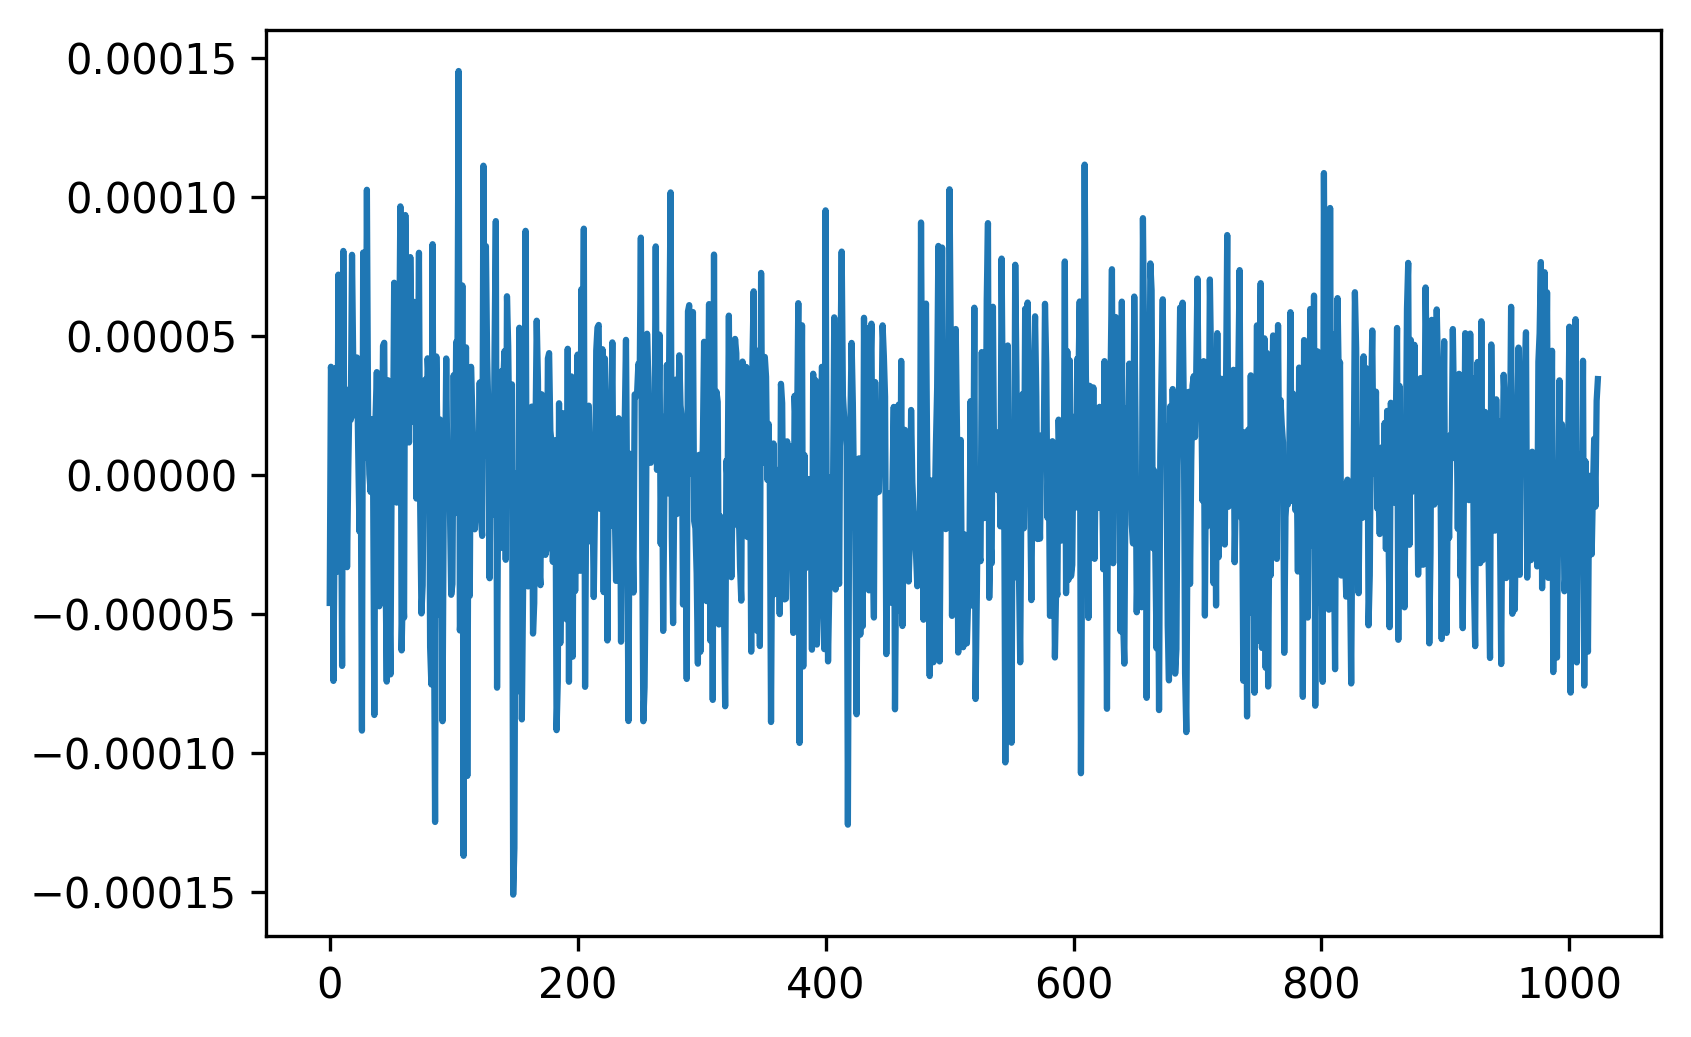

In [14]:
plt.plot(lks['c06_w05_smooth08_tns0500_ign[()]_s11()_antsimFalse_fg5_simulTrue_taufxTrue_ns01_nd01'].data['q']['ambient'] - lks['c06_w05_smooth08_tns0500_ign[()]_s11()_antsimFalse_fg5_simulTrue_taufxTrue_ns01_nd01_noiseFalse'].data['q']['ambient'])

In [14]:
lk = mcmc.precal.get_likelihood(smooth=32, tns_width=5, add_noise=False, s11_sys=('short', 'open'))

6 6 6
('hot_load', 'ambient', 'short', 'open') False


In [15]:
ctx = lk.partial_linear_model.get_ctx()

In [18]:
model = lk.partial_linear_model.reduce_model(ctx)

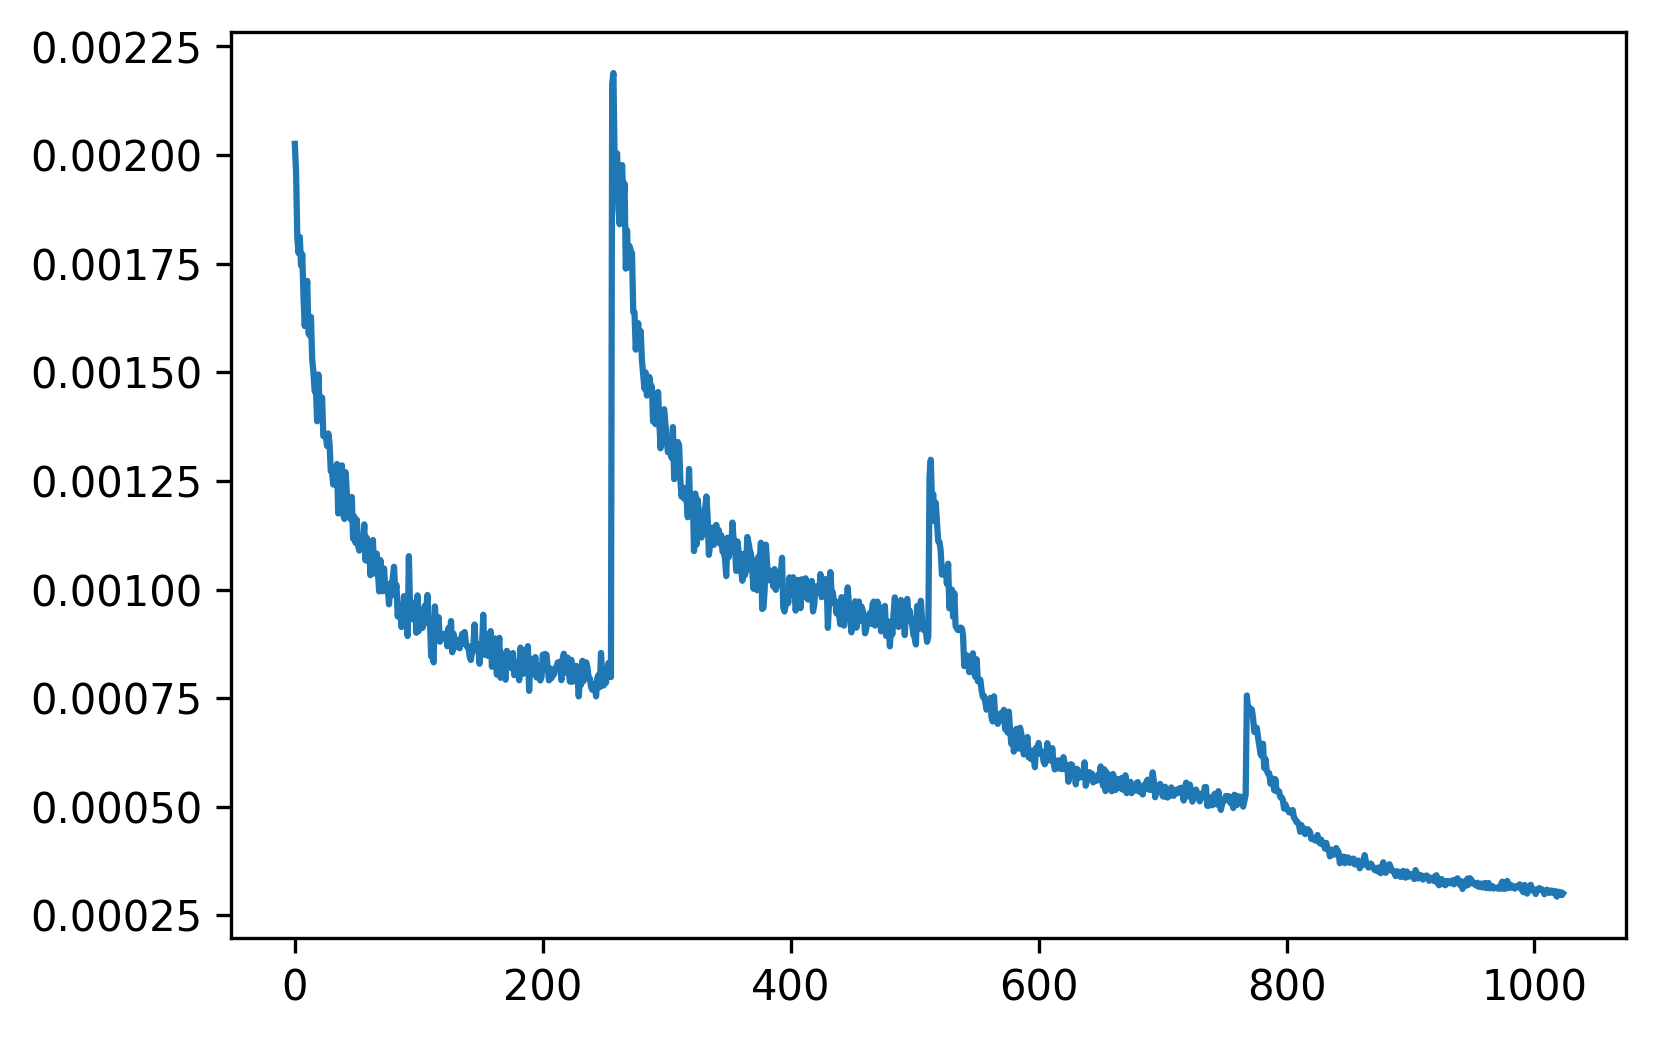

In [21]:
plt.plot(model[2])

In [23]:
lk.partial_linear_model.data_func

<bound method NoiseWaveLikelihood.transform_data of <class 'edges_estimate.likelihoods.NoiseWaveLikelihood'>>

In [22]:
model[0].residual

array([ 1.19371180e-12,  9.66338121e-13,  1.02318154e-12, ...,
       -3.69482223e-13, -5.11590770e-13, -5.54223334e-13])

In [24]:
from yabf import run_map

In [25]:
res = run_map(lk.partial_linear_model)

In [26]:
res.x

array([ 1.48567817e+03, -1.94835467e+02,  6.28489689e+01, -1.86395779e+01,
        6.60235276e+00, -3.45500692e+00, -6.87648090e-06, -4.36719554e-06,
       -6.88045145e-06, -2.36264005e-06])

In [27]:
lk.partial_linear_model.logp(params=res.x)

3592.424514349724

In [28]:
lk.partial_linear_model.logp()

3592.4238464627692

In [39]:
res2 = run_map(lk.partial_linear_model, basinhopping_kw={'niter': 20})

In [40]:
res2

                        fun: -3592.424514349724
 lowest_optimization_result:       fun: -3592.424514349724
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([-7.06684857e-02, -1.29330044e-01, -4.77939426e-02, -8.45375255e-02,
       -3.61069399e-02, -6.45741242e-02,  3.91427466e+02, -3.05180947e-01,
        8.51374807e+01,  3.15549187e-01])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 77
      nit: 2
     njev: 7
   status: 0
  success: True
        x: array([ 1.48567817e+03, -1.94835467e+02,  6.28489689e+01, -1.86395779e+01,
        6.60235276e+00, -3.45500692e+00, -6.87648090e-06, -4.36719554e-06,
       -6.88045145e-06, -2.36264005e-06])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 7623
                        nit: 20
                       njev: 693
                    success: True
                          x: array(

In [41]:
[p.fiducial for p in lk.partial_linear_model.child_active_params]

[1485.6792190553897,
 -194.8354195885617,
 62.84931729236473,
 -18.63954952360565,
 6.602561532221233,
 -3.4549865882564075,
 0.0,
 0.0,
 0.0,
 0.0]

In [36]:
lk.partial_linear_model.logp(params=res2.x)

3588.1810631742223

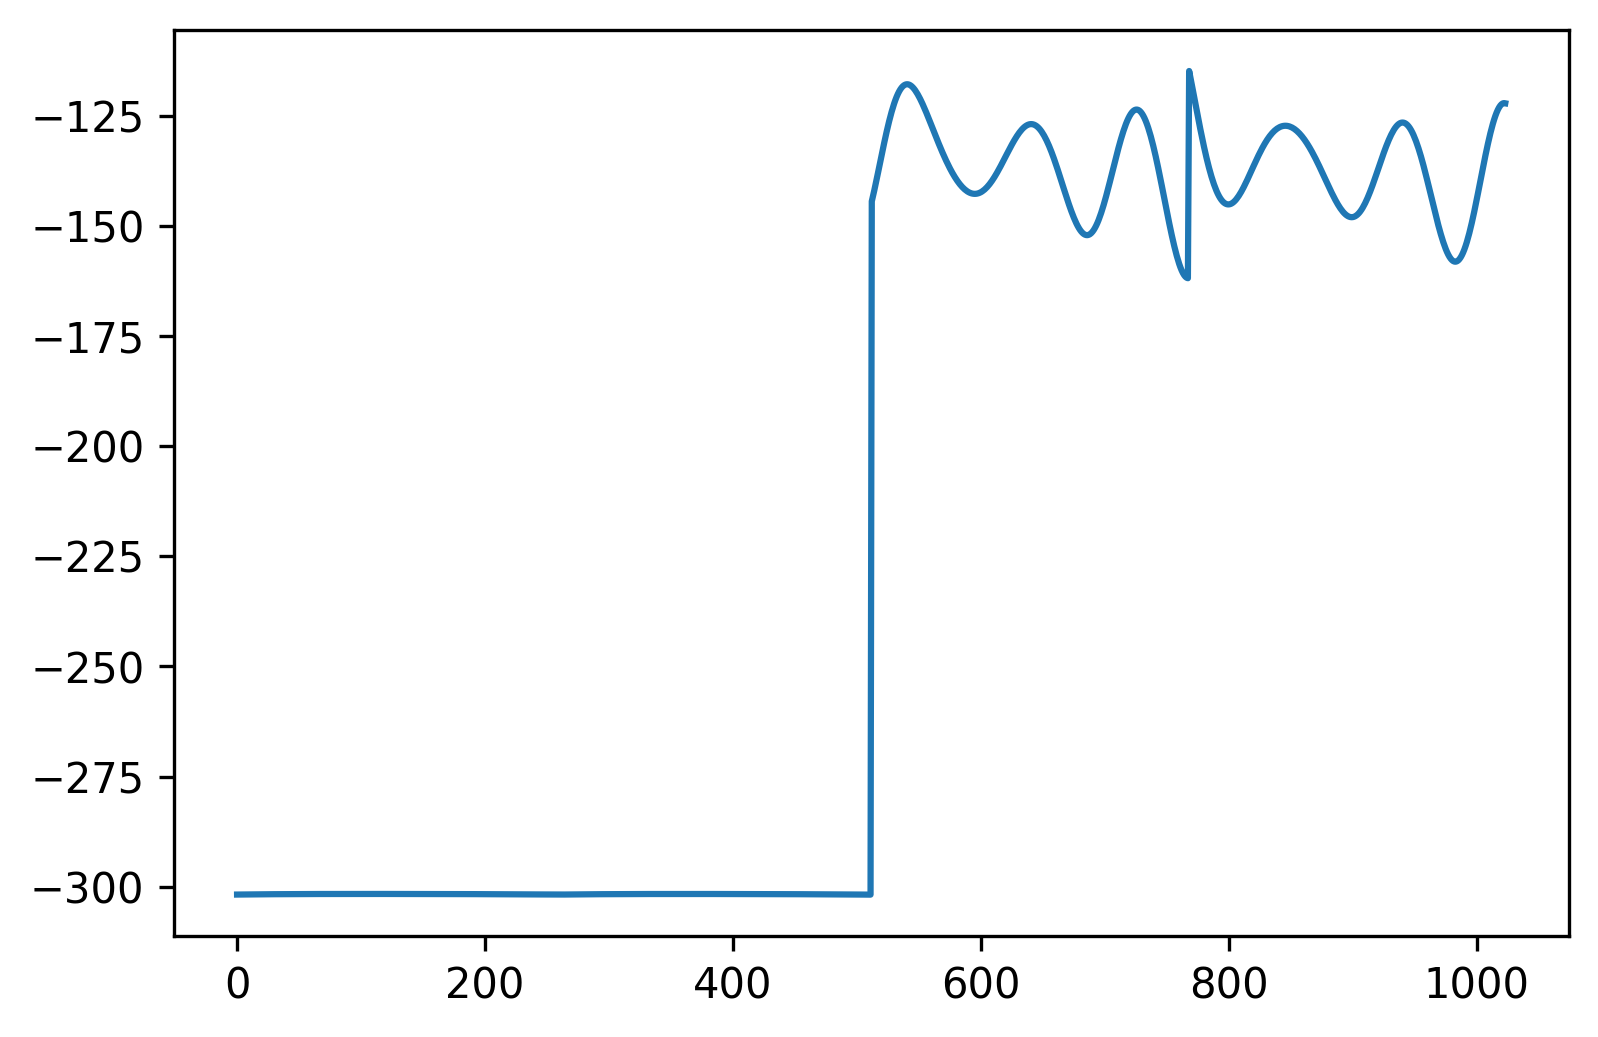

In [20]:
plt.plot(model[1])

In [ ]:
lk = mcmc.precal.get_likelihood()

In [ ]:
lk = mcmc.get_likelihood